<a href="https://colab.research.google.com/github/geoffwoollard/compSPI/blob/gw/notebooks/fast_projections_numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Implement += with no race condition
* https://stackoverflow.com/questions/59596794/understanding-this-race-condition-in-numba-parallelization
* https://stackoverflow.com/questions/61372937/avoid-race-condition-in-numba
* https://numba.pydata.org/numba-doc/latest/user/parallel.html

# Setup

In [4]:
!rm coords.py, gauss_forward_model.py
!wget https://raw.githubusercontent.com/geoffwoollard/compSPI/80bdda9ae51c462baaefd2cdefb860cb4ef72167/src/coords.py
!wget https://raw.githubusercontent.com/geoffwoollard/compSPI/80bdda9ae51c462baaefd2cdefb860cb4ef72167/src/gauss_forward_model.py
import coords, gauss_forward_model

rm: cannot remove 'coords.py,': No such file or directory
--2021-04-17 18:33:08--  https://raw.githubusercontent.com/geoffwoollard/compSPI/80bdda9ae51c462baaefd2cdefb860cb4ef72167/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2603 (2.5K) [text/plain]
Saving to: ‘coords.py.10’

coords.py.10        100%[===================>]   2.54K  --.-KB/s    in 0s      

2021-04-17 18:33:08 (42.1 MB/s) - ‘coords.py.10’ saved [2603/2603]

--2021-04-17 18:33:08--  https://raw.githubusercontent.com/geoffwoollard/compSPI/80bdda9ae51c462baaefd2cdefb860cb4ef72167/src/gauss_forward_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

In [1]:
import numpy as np
import numba as nb
import pandas as pd
import math
import matplotlib.pyplot as plt
def doplt(arr2d,cmap='gray',**kwargs):
  plt.imshow(arr2d,cmap=cmap,**kwargs)

# Atoms, grid, precomputed idx

In [34]:
n_atoms = 300
N = 16
pad = 0.2
np.random.seed(0)
atoms = np.random.uniform(low=-N/2+pad*N,high=N/2-pad*N,size=3*n_atoms).reshape(3,n_atoms)
atoms.shape

(3, 300)

In [38]:
xy = coords.coords_n_by_d(np.arange(-N//2,N//2),d=2)

In [39]:
N = np.sqrt(xy.shape[0]).astype(int)
X = np.round(atoms[0]).astype(np.int32) + N//2
Y = np.round(atoms[1]).astype(np.int32) + N//2
idx = X+N*Y
idx


array([200, 186, 105,  72, 119,  89,  71,  76, 172,  55, 187,  88,  73,
        76, 164, 100, 115, 155, 187, 172, 109,  75,  72, 107, 100, 137,
       165, 172, 104, 119,  86, 187,  72, 169, 179, 185, 105, 121, 156,
       106, 119,  87, 138,  68, 186,  74, 133, 100, 150, 199, 153,  71,
       125, 132, 133, 165, 105,  70, 120, 198,  85, 196, 138, 133, 197,
       135, 171, 116, 203, 164, 173, 104, 173, 153, 106,  84, 182, 196,
       134, 148, 182, 135, 196, 154, 185, 198, 184,  84, 153, 124,  70,
       122, 100, 186,  70, 197, 121, 115,  59,  83, 122, 198,  74, 204,
       198, 137, 105,  89, 149,  76,  55, 123,  74, 102,  91, 103,  76,
        57,  76, 154, 218, 216, 124,  89, 151, 137, 211,  70, 186, 102,
       105, 167, 101, 166, 137, 121, 153, 105, 169, 119, 124, 183, 199,
        76,  91, 122, 180, 220, 218, 205, 101, 220, 101,  73, 196,  91,
       171,  73, 167, 196, 106, 120, 122, 172,  93,  91, 131, 103, 186,
        85, 136, 196, 149, 195, 203, 165, 167, 204, 218, 132,  6

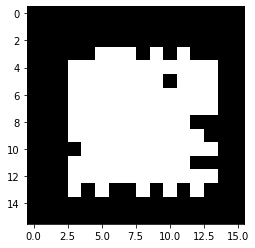

In [40]:
delta = np.zeros(N*N)
delta[idx]=1
doplt(delta.reshape(N,N))

# `make_map_3d.sum`

In [41]:
sigma=.5
xyz = coords.coords_n_by_d(np.arange(-N//2,N//2),d=3)
map_3d = gauss_forward_model.make_map_3d(atoms,xyz,N,sigma)

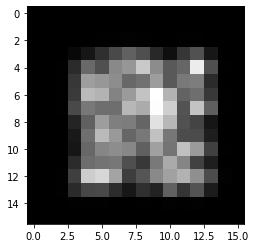

In [42]:
doplt(map_3d.sum(-1).T)

In [43]:
@nb.njit(parallel=True)
def parallel_add_patch_including_diff(xy,N,atoms,idx,n_trunc,sigma):
  nt_ = (n_trunc-1)//2
  a = -1/(2*sigma**2)
  g_2d = np.zeros(N*N)
  for i in nb.prange(idx.shape[0]): # loop over atoms
    patch_line = np.arange(idx[i]-nt_,idx[i]+nt_+1,1)
    for y_line in nb.prange(-nt_,+nt_+1,1):
      one_gauss_patch_y_line_idxs = patch_line + y_line*N

      diffx = xy[one_gauss_patch_y_line_idxs,0] - atoms[0,i]
      diffy = xy[one_gauss_patch_y_line_idxs[0],1] - atoms[1,i] # all ys the same
      d2i = diffx*diffx+diffy*diffy
      gi_y_line = np.exp(a*d2i)
      
      g_2d[one_gauss_patch_y_line_idxs] += gi_y_line

  return(g_2d)

In [49]:
sigma=.5
g_2d = parallel_add_patch_including_diff(xy,N,atoms,idx,n_trunc=int(6*sigma),sigma=sigma)


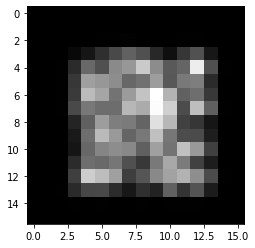

In [48]:
doplt(g_2d.reshape(N,N))

Although everything look alright, it actually isn't. There is a racing condition in the code in the += to a slice of an array, which isn't supported. Running the function twice ends up with two different answers because of the racing condition. 

In [ ]:
g_2d_1 = parallel_add_patch_including_diff(xy,N,atoms,idx,n_trunc=int(6*sigma),sigma=sigma)
g_2d_2 = parallel_add_patch_including_diff(xy,N,atoms,idx,n_trunc=int(6*sigma),sigma=sigma)

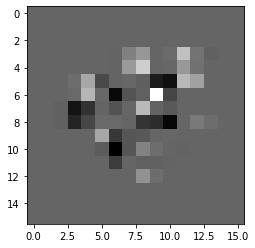

In [53]:
doplt((g_2d_1-g_2d_2).reshape(N,N))

It doesn't seem possible to solve the rance condition still using prange and +=, since we will have to add into an array element. Instead let's try something else in numba

# `nb.guvectorize`

## warm up example

In [21]:
@nb.guvectorize([(nb.int64[:], nb.int64, nb.int64[:])], '(n),()->(n)')
def g(x, y, res):
    for i in range(x.shape[0]):
        res[i] = x[i] + y

In [22]:
res = np.zeros(3).astype(np.int64)
g(np.arange(3),10,res)

array([10, 11, 12])

## 1D window

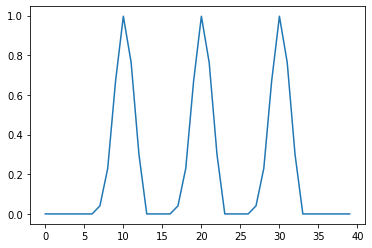

In [26]:
idx = np.array([10,20,30])
# atoms = np.zeros((2,3))
# atoms = idx + 0.1
atoms = np.zeros((2,3))
atoms[0] = idx + 0.1

empty = np.zeros(40)
res = np.zeros(40)
@nb.guvectorize([(nb.float64[:],nb.float64[:,:], nb.int64[:], nb.float64[:])], '(N2),(r2,n_atoms),(n_atoms)->(N2)')
def g(empty,atoms, idx, res):
    sigma=3.
    for i in range(atoms.shape[1]):
        for offset in range(-3,3):
          #res[i] = atoms[i]
          diff = atoms[0,i] - idx[i] - offset
          res[idx[i]+offset] = np.exp(-diff*diff/sigma)
    #return(res)
pd.Series(g(empty,atoms, idx, res)).plot()

## 2D

In [7]:
n_atoms = 10000
N = 128
pad = 0.2
np.random.seed(0)
atoms = np.random.uniform(low=-N/2+pad*N,high=N/2-pad*N,size=3*n_atoms).reshape(3,n_atoms)
atoms.shape

(3, 10000)

In [8]:
xy = coords.coords_n_by_d(np.arange(-N//2,N//2),d=2)

In [9]:
N = np.sqrt(xy.shape[0]).astype(int)
def idx_from_atoms(atoms,N):
  X = np.round(atoms[0]).astype(np.int32) + N//2
  Y = np.round(atoms[1]).astype(np.int32) + N//2
  idx = X+N*Y
  return(idx)
idx = idx_from_atoms(atoms,N)
%time idx_from_atoms(atoms,N)
idx.shape

CPU times: user 0 ns, sys: 1.26 ms, total: 1.26 ms
Wall time: 983 µs


(10000,)

### CPU

In [49]:
@nb.guvectorize([(nb.float64[:,:],nb.int64,nb.float64[:,:],nb.int64[:],nb.int64,nb.float64,nb.float64[:])], '(N2,r2),(),(r2,n_atoms),(n_atoms),(),()->(N2)',nopython=True,target='cpu')
def precompute_idx_ntrunc(xy,N,atoms,idx,n_trunc,sigma,g_2d):
  nt_ = (n_trunc-1)//2
  a = -1/(2*sigma**2) # sigma in pixel units
  for i in range(idx.shape[0]): # loop over atoms
    for x_idx in range(idx[i]-nt_,idx[i]+nt_+1,1):
      for y_idx in range(-nt_,+nt_+1,1):
        xy_idx = x_idx + y_idx*N
        diffx = xy[xy_idx,0] - atoms[0,i] # atom locations in pixel units
        diffy = xy[xy_idx,1] - atoms[1,i]
        d2i = diffx*diffx+diffy*diffy
        gi = math.exp(a*d2i)
        g_2d[xy_idx] += gi # check no racing condition
# del g_2d
g_2d = np.zeros(N*N)
sigma=1
n_trunc = np.int64(6*sigma)
# g_2d = precompute_idx_ntrunc(xy,N,atoms[:2,:],idx,n_trunc,sigma,g_2d)

In [50]:
%time precompute_idx_ntrunc(xy,N,atoms[:2],idx,n_trunc,sigma,g_2d)
g_2d = precompute_idx_ntrunc(xy,N,atoms[:2],idx,n_trunc,sigma,g_2d)

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 9.73 ms


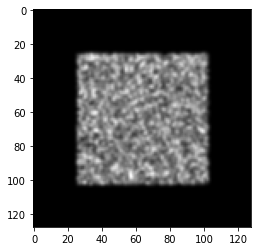

In [51]:
doplt(g_2d.reshape(N,N))

In [52]:
N = 128
pad = 0.2
np.random.seed(0)
xy = coords.coords_n_by_d(np.arange(-N//2,N//2),d=2)
xy[:,[0,1]] = xy[:,[1,0]]
sigma=.5
n_trunc = np.int64(6*sigma)
precompute_idx_ntrunc_t=[]
parallel_add_patch_including_diff_t=[]
n_atoms_list = [100,300,1000,3000,10000,30000,100000]
for n_atoms in n_atoms_list:
  atoms = np.random.uniform(low=-N/2+pad*N,high=N/2-pad*N,size=3*n_atoms).reshape(3,n_atoms)
  X = np.round(atoms[0]).astype(np.int32) + N//2
  Y = np.round(atoms[1]).astype(np.int32) + N//2
  idx = X+N*Y
  g_2d = np.zeros(N*N)
  t = %timeit -o precompute_idx_ntrunc(xy,N,atoms[:2,:],idx,n_trunc,sigma,g_2d)
  precompute_idx_ntrunc_t.append(t.best)

  t = %timeit -o gauss_forward_model.parallel_add_patch_including_diff(xy,N,atoms,idx,n_trunc=n_trunc,sigma=sigma)
  parallel_add_patch_including_diff_t.append(t.best)

10000 loops, best of 5: 28.2 µs per loop
The slowest run took 10283.68 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 206 µs per loop
The slowest run took 11.51 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 69.5 µs per loop
1000 loops, best of 5: 565 µs per loop
1000 loops, best of 5: 224 µs per loop
1000 loops, best of 5: 1.84 ms per loop
1000 loops, best of 5: 625 µs per loop
100 loops, best of 5: 5.47 ms per loop
100 loops, best of 5: 2.05 ms per loop
100 loops, best of 5: 18.6 ms per loop
100 loops, best of 5: 6.06 ms per loop
10 loops, best of 5: 56.3 ms per loop
10 loops, best of 5: 20.5 ms per loop
10 loops, best of 5: 180 ms per loop


Text(0.5, 1.0, '2D projection scaling: 3x3 patch truncation')

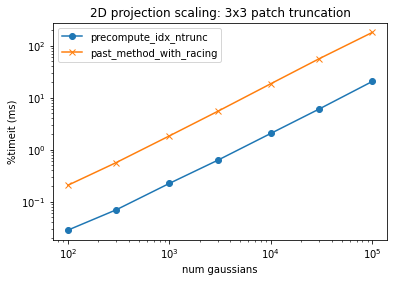

In [53]:
s_to_ms=1000
sr = pd.Series(precompute_idx_ntrunc_t)*s_to_ms
sr.index = n_atoms_list
sr.plot(logx=True,logy=True,label='precompute_idx_ntrunc',legend=True,marker='o')

sr = pd.Series(parallel_add_patch_including_diff_t)*s_to_ms
sr.index = n_atoms_list
sr.plot(logx=True,logy=True,label='past_method_with_racing',legend=True,marker='x')

plt.xlabel('num gaussians')
plt.ylabel('%timeit (ms)')
plt.title('2D projection scaling: %ix%i patch truncation'%(n_trunc,n_trunc))

In [54]:
sr = pd.Series(precompute_idx_ntrunc_t)*s_to_ms
sr.index = n_atoms_list

(sr.iloc[-1] - sr.iloc[-2]) / (sr.index[-1]-sr.index[-2])

0.0002066993571427247

In [55]:
precompute_idx_ntrunc_t

[2.8208245399991938e-05,
 6.954824079998616e-05,
 0.0002237097290001202,
 0.0006251221800000621,
 0.002052803659998972,
 0.006057288300000891,
 0.02052624329999162]

#### rotation inside

In [94]:
%%time
n_proj=100
np.random.seed(0)
qs = coords.get_random_quat(n_proj)
Rs = coords.quaternion_to_R(qs.T)
print(Rs.shape)

(3, 3, 100)
CPU times: user 765 µs, sys: 0 ns, total: 765 µs
Wall time: 618 µs


In [95]:
%%time
N_vec= N*np.ones(atoms.shape[1]).astype(np.int64)
n_trunc_vec =n_trunc*np.ones(atoms.shape[1]).astype(np.int64)
sigma_vec = sigma*np.ones(atoms.shape[1]).astype(np.float64)


CPU times: user 298 µs, sys: 0 ns, total: 298 µs
Wall time: 340 µs


In [96]:
@nb.guvectorize([(nb.float64[:,:,:],nb.float64[:,:],nb.int64[:],nb.float64[:,:],nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:,:])], '(r2,r3,n_proj),(N2,r2),(n_atoms),(r3,n_atoms),(n_atoms),(n_atoms),(n_atoms)->(n_proj,N2)',nopython=True,target='cpu')
def precompute_idx_ntrunc_rot_cpu(Rs,xy,N,atoms,idx,n_trunc,sigma,g_2d):
  for proj_idx in range(Rs.shape[-1]):
    R = Rs[:,:,proj_idx]
    #atoms_rot = Rs[:2,:,proj_idx].dot(atoms) # only need to rotate x and y coord (only two of three rows in R)
    #atoms_rot = np.dot(Rs[:2,:,proj_idx],atoms[:,:])

    for i in range(idx.shape[0]): # loop over atoms
      nt_ = (n_trunc[i]-1)//2
      a = -1/(2*sigma[i]*sigma[i]) # sigma in pixel units

      x = atoms[0,i]
      y = atoms[1,i]
      z = atoms[2,i]

      # code dot product explicitly
      x_rot = R[0,0]*x + R[0,1]*y + R[0,2]*z
      y_rot = R[1,0]*x + R[1,1]*y + R[1,2]*z

      X = round(x_rot) + N[i]//2
      Y = round(y_rot) + N[i]//2
      idx[i] = X+N[i]*Y

      
      for x_idx in range(idx[i]-nt_,idx[i]+nt_+1,1): 
        for y_idx in range(-nt_,+nt_+1,1):
          xy_idx = x_idx + y_idx*N[i]
          diffx = xy[xy_idx,0] - x_rot #atoms[0,i] # atom locations in pixel units
          diffy = xy[xy_idx,1] - y_rot # atoms[1,i]
          d2i = diffx*diffx+diffy*diffy
          gi = math.exp(a*d2i)
          g_2d[proj_idx,xy_idx] += gi # check no racing condition
del g_2d
g_2d = np.zeros((n_proj,N*N))
g_2d = precompute_idx_ntrunc_rot_cpu(Rs[:2,:,:],xy,N_vec,atoms[:3,:],idx,n_trunc_vec,sigma_vec,g_2d)

In [ ]:
%time precompute_idx_ntrunc_rot_cpu(Rs[:2,:,:],xy,N_vec,atoms[:3,:],idx,n_trunc_vec,sigma_vec,g_2d)

In [ ]:
doplt(g_2d[0].reshape(N,N))

In [ ]:
doplt(g_2d[1].reshape(N,N))

### cuda (rotation inside)

In [100]:
n_atoms = 10000
N = 128
pad = 0.2
np.random.seed(0)
atoms = np.random.uniform(low=-N/2+pad*N,high=N/2-pad*N,size=3*n_atoms).reshape(3,n_atoms)
atoms.shape

(3, 10000)

In [101]:
xy = coords.coords_n_by_d(np.arange(-N//2,N//2),d=2)

In [102]:
N = np.sqrt(xy.shape[0]).astype(int)
X = np.round(atoms[0]).astype(np.int32) + N//2
Y = np.round(atoms[1]).astype(np.int32) + N//2
idx = X+N*Y

In [103]:
@nb.guvectorize([(nb.float64[:,:,:],nb.float64[:,:],nb.int64[:],nb.float64[:,:],nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:,:])], '(r2,r3,n_proj),(N2,r2),(n_atoms),(r3,n_atoms),(n_atoms),(n_atoms),(n_atoms)->(n_proj,N2)',nopython=True,target='cuda')
def precompute_idx_ntrunc_rot_gpu(Rs,xy,N,atoms,idx,n_trunc,sigma,g_2d):
  for proj_idx in range(Rs.shape[-1]):
    R = Rs[:,:,proj_idx]

    for i in range(idx.shape[0]): # loop over atoms
      nt_ = (n_trunc[i]-1)//2
      a = -1/(2*sigma[i]*sigma[i]) # sigma in pixel units

      x = atoms[0,i]
      y = atoms[1,i]
      z = atoms[2,i]

      # code dot product explicitly
      x_rot = R[0,0]*x + R[0,1]*y + R[0,2]*z
      y_rot = R[1,0]*x + R[1,1]*y + R[1,2]*z

      X = round(x_rot) + N[i]//2
      Y = round(y_rot) + N[i]//2
      idx[i] = X+N[i]*Y

      for x_idx in range(idx[i]-nt_,idx[i]+nt_+1,1): 
        for y_idx in range(-nt_,+nt_+1,1):
          xy_idx = x_idx + y_idx*N[i]
          diffx = xy[xy_idx,0] - x_rot  # atom locations in pixel units
          diffy = xy[xy_idx,1] - y_rot 
          d2i = diffx*diffx+diffy*diffy
          gi = math.exp(a*d2i)
          g_2d[proj_idx,xy_idx] += gi # check no racing condition
del g_2d

In [104]:
%%time
N=128
n_proj=50
sigma=1
g_2d = np.zeros((n_proj,N*N))
n_trunc = np.int64(6*sigma)

CPU times: user 2.94 ms, sys: 0 ns, total: 2.94 ms
Wall time: 1.93 ms


In [105]:
%%time
np.random.seed(0)
qs = coords.get_random_quat(n_proj)
Rs = coords.quaternion_to_R(qs.T)
print(Rs.shape)

(3, 3, 50)
CPU times: user 157 µs, sys: 1.07 ms, total: 1.22 ms
Wall time: 973 µs


In [106]:
%%time
Rs_gpu = nb.cuda.to_device(Rs[:2,:,:])
N_gpu = nb.cuda.to_device(N*np.ones(atoms.shape[1]).astype(np.int64))
n_trunc_gpu = nb.cuda.to_device(n_trunc*np.ones(atoms.shape[1]).astype(np.int64))
sigma_gpu = nb.cuda.to_device(sigma*np.ones(atoms.shape[1]).astype(np.float64))
xy_gpu = nb.cuda.to_device(xy)
atoms_gpu = nb.cuda.to_device(atoms[:3,:])
idx_gpu = nb.cuda.to_device(idx.astype(np.int64))
g_2d_gpu = nb.cuda.to_device(g_2d)

CPU times: user 6.51 ms, sys: 2.19 ms, total: 8.7 ms
Wall time: 8.14 ms


In [107]:
%time gauss_forward_model.precompute_idx_ntrunc_rot_gpu(Rs_gpu,xy_gpu,N_gpu,atoms_gpu[:3,:],idx_gpu,n_trunc_gpu,sigma_gpu,g_2d_gpu)
# precompute_idx_ntrunc_rot_gpu(Rs_gpu,xy_gpu,N_gpu,atoms_gpu[:3,:],idx_gpu,n_trunc_gpu,sigma_gpu,g_2d_gpu)

CPU times: user 5.13 ms, sys: 1.04 ms, total: 6.17 ms
Wall time: 5.32 ms


In [108]:
%time g_2d_cpu = g_2d_gpu.copy_to_host()
# g_2d_cpu = g_2d_gpu.copy_to_host()
# TODO: g_2d_gpu.to_host() what is the difference

CPU times: user 2.88 s, sys: 2.48 s, total: 5.36 s
Wall time: 5.35 s


In [109]:
g_2d_gpu.shape

(50, 16384)

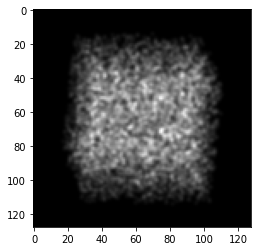

In [110]:
doplt(g_2d_cpu[0].reshape(N,N))